In [1]:
! cat modules.py

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm

In [2]:
import os
from torchvision.datasets import FashionMNIST
from torchvision import transforms

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from modules import *

In [3]:
sns.set()

FASITON_MNIST_PATH = "dataset/FashionMNIST"
DEVICE = "cpu"  # if GPU, add device="cuda:0"

---

## 4.2 CNNによる画像分類

### 4.2.1 Fashion-MNIST

In [4]:
# Fashion-MNIST のデータから DataLoader を作成
def load_fasion_mnist(filepath, download=False):
    """
    訓練用データの取得
    そのままだとPIL（Python Imaging Library）の画像形式で Dataset を作ってしまうので、
    transforms.ToTensor で Tensor に変換する
    """
    if os.path.exists("dataset") is False: 
        os.mkdir("dataset")
    fashion_mnist_train = FashionMNIST(filepath, train=True, download=download, transform=transforms.ToTensor())
    fashion_mnist_test = FashionMNIST(filepath, train=False, download=download, transform=transforms.ToTensor())
    return fashion_mnist_train, fashion_mnist_test

In [25]:
# データをロード
fashion_mnist_train, fashion_mnist_test = load_fasion_mnist(FASITON_MNIST_PATH, download=False)

# バッチサイズが128の DataLoader をそれぞれ作成
batch_size = 128
train_loader = DataLoader(fashion_mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(fashion_mnist_test, batch_size=batch_size, shuffle=True)

### 4.2.2 CNN の構築と学習

In [5]:
# 2層の畳み込み層と2層の MLP をつなげた CNN を作成

"""
(N, C, H, W) 形式を Tensor を (N, C*H*W) に引き伸ばす層
畳み込み層の出力を MLP にわたす際に必要
N: 値の行数, C: チャネル数, H: Height, W: Width
"""
class FlattenLayer(nn.Module):
    def forward(self, x):
        sizes = x.size()
        return x.view(sizes[0], -1)
    
"""
2層の畳み込み層
"""
conv_net = nn.Sequential(
    nn.Conv2d(1, 32, 5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Dropout2d(0.25),
    nn.Conv2d(32, 64, 5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Dropout2d(0.25),
    FlattenLayer()
)

"""
畳み込み層の出力をフラットにして、最後に2層の単純なMLPに接続する
フラットにした場合の次元数は、直前がN次元の場合 各次元の積の値になる
"""
test_input = torch.ones(1, 1, 28, 28)  # ダミーデータ
conv_output_size = conv_net(test_input).size()[-1]

# 2層の NLP
mlp = nn.Sequential(
    nn.Linear(conv_output_size, 200),
    nn.ReLU(),
    nn.BatchNorm1d(200),
    nn.Dropout(0.25),
    nn.Linear(200, 10)
)

# 最終的な CNN
net = nn.Sequential(
    conv_net,
    mlp
)

In [6]:
# 評価のヘルパー関数
def eval_net(net, data_loader, device='cpu'):
    # Dropout や BatchNorm を無効化
    net.eval()  # ネットワークを評価モードにする
    
    ys = []
    ypreds = []
    for x, y in data_loader:
        # toメソッドで計算を実行するデバイスに転送する
        x = x.to(device)
        y = y.to(device)
        
        # 確率が最大のクラスを予測（リスト2.14参照）
        # ここでは forward(推論)の計算だけなので自動微分に
        # 必要な処理は off にして余計な計算を省く
        with torch.no_grad():
            _, y_pred = net(x).max(1)
        ys.append(y)
        ypreds.append(y_pred)
    
    # ミニバッチごとの予測結果などを1つにまとめる
    ys = torch.cat(ys)
    ypreds = torch.cat(ypreds)
    
    # 予測精度を計算
    acc = (ys == ypreds).float().sum() / len(ys)
    return acc.item()

In [7]:
# 訓練のヘルパー関数
def train_net(net, train_loader, test_loader, 
              optimizer_cls=optim.Adam, loss_fn=nn.CrossEntropyLoss(), n_iter=10, device="cpu"):
    train_losses = []
    train_acc = []
    val_acc = []
    optimizer = optimizer_cls(net.parameters())
    
    for epoch in range(n_iter):
        running_loss = 0.0
        net.train()  # ネットワークを訓練モードにする
        n = 0
        n_acc = 0
        
        # 非常に時間がかかるので tqdm を使用してプログレスモードを出す
        for i, (xx, yy) in tqdm(enumerate(train_loader), total=len(train_loader)):
            xx = xx.to(device)
            h = net(xx)
            loss = loss_fn(h, yy)
            optimizer.zero_grad()  # 勾配の値を初期化
            loss.backward()  # loss の w による微分を計算
            optimizer.step()  # 勾配を更新する
            running_loss += loss.item()
            
            n += len(xx)
            _, y_pred = h.max(1)  # return (max_values, argmax)
            n_acc += (yy == y_pred).float().sum().item()
        
        train_losses.append(running_loss / i)  # 収束確認のために loss を記録しておく
        
        # 訓練データの予測精度
        train_acc.append(n_acc / n)
        
        # 検証データの予測精度
        val_acc.append(eval_net(net, test_loader, device))
        
        # この epoch での結果を表示: リストに追加された最新の値を取り出す
        print(epoch, train_losses[-1], train_acc[-1], val_acc[-1], flush=True)  # flush: pythonで print の出力結果を即時・強制表示させる（主にjupyter）
        
    return net, train_losses, train_acc, val_acc

In [46]:
# ネットワークの全パラメータを GPU に転送
# net.to("cuda:0")

# 訓練を実行
net, train_losses, train_acc, val_acc = train_net(net, train_loader, test_loader, n_iter=2, device=DEVICE)  # if GPU, add device="cuda:0" to argument

100%|██████████| 469/469 [11:07<00:00,  1.36s/it]


0 0.4607887307548115 0.8410166666666666 0.8820000290870667


100%|██████████| 469/469 [19:20<00:00,  1.51s/it]


1 0.31289041777833915 0.8851666666666667 0.8977000117301941


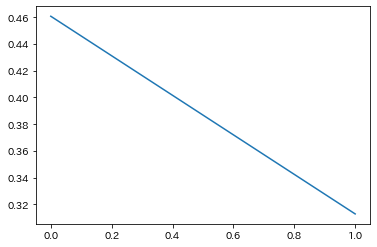

In [49]:
plt.plot(train_losses)
plt.show()

---

## 4.3 転移学習

### 4.3.1 データの準備

In [8]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

In [9]:
def load_data(path, train_test):
    if train_test == "train":
        crop_style = transforms.RandomCrop(224)
        shuffle = True
    elif train_test == "test":
        crop_style = transforms.CenterCrop(224)
        shuffle = False
    imgs = ImageFolder(path, transform=transforms.Compose([crop_style, transforms.ToTensor()]))
    loader = DataLoader(imgs, batch_size=32, shuffle=shuffle)
    return loader

In [53]:
TRAIN_PATH = "./dataset/taco_and_burrito/train/"
TEST_PATH = "./dataset/taco_and_burrito/test/"
train_loader = load_data(TRAIN_PATH, train_test="train")
test_loader = load_data(TEST_PATH, train_test="test")

### 4.3.2 PyTorch で転移学習

In [10]:
from torchvision import models

In [59]:
# 事前学習済みの resnet18 をロード
net = models.resnet18(pretrained=True)

# すべてのパラメータを微分対象外にする
for p in net.parameters():
    p.requires_grad = False
    
# 最後の線形層を付け替える
fc_input_dim = net.fc.in_features
net.fc = nn.Linear(fc_input_dim, 2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/takayukiishikawa/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:10<00:00, 4525461.43it/s]


In [65]:
net, train_losses, train_acc, val_acc = train_net(net, train_loader, test_loader, n_iter=10, device=DEVICE)  # if GPU, add device="cuda:0" to argument

100%|██████████| 23/23 [01:39<00:00,  4.21s/it]


0 0.47423957830125635 0.8089887640449438 0.8166666626930237


100%|██████████| 23/23 [02:01<00:00,  3.94s/it]


1 0.44614343074235047 0.8089887640449438 0.8666666746139526


100%|██████████| 23/23 [01:59<00:00,  4.54s/it]


2 0.4122938947244124 0.8384831460674157 0.8500000238418579


100%|██████████| 23/23 [01:31<00:00,  2.70s/it]


3 0.410941288552501 0.8300561797752809 0.8166666626930237


100%|██████████| 23/23 [01:30<00:00,  3.38s/it]


4 0.3767673115838658 0.8497191011235955 0.8666666746139526


100%|██████████| 23/23 [01:42<00:00,  2.97s/it]


5 0.4031787169250575 0.827247191011236 0.8666666746139526


100%|██████████| 23/23 [01:37<00:00,  4.20s/it]


6 0.39332754706794565 0.8286516853932584 0.7833333611488342


100%|██████████| 23/23 [01:43<00:00,  5.24s/it]


7 0.3626637709411708 0.8426966292134831 0.8166666626930237


100%|██████████| 23/23 [01:44<00:00,  3.19s/it]


8 0.35544049672105094 0.8525280898876404 0.8500000238418579


100%|██████████| 23/23 [01:22<00:00,  2.97s/it]


9 0.3189194845882329 0.8778089887640449 0.8666666746139526


100%|██████████| 23/23 [01:30<00:00,  2.90s/it]


10 0.34394983608614316 0.8665730337078652 0.8666666746139526


100%|██████████| 23/23 [01:19<00:00,  2.68s/it]


11 0.33698765290054405 0.8623595505617978 0.8333333134651184


100%|██████████| 23/23 [01:17<00:00,  2.75s/it]


12 0.33844502337954263 0.8553370786516854 0.8666666746139526


100%|██████████| 23/23 [01:37<00:00,  3.08s/it]


13 0.3499913547526706 0.8581460674157303 0.8833333253860474


100%|██████████| 23/23 [01:33<00:00,  3.29s/it]


14 0.3038768842816353 0.8862359550561798 0.8999999761581421


100%|██████████| 23/23 [01:40<00:00,  3.30s/it]


15 0.3095882467248223 0.8862359550561798 0.8833333253860474


100%|██████████| 23/23 [01:31<00:00,  3.40s/it]


16 0.30982310053977097 0.8679775280898876 0.8666666746139526


100%|██████████| 23/23 [01:31<00:00,  3.96s/it]


17 0.31040924245660956 0.8693820224719101 0.8833333253860474


100%|██████████| 23/23 [01:52<00:00,  3.71s/it]


18 0.31156552312048996 0.8834269662921348 0.8666666746139526


100%|██████████| 23/23 [02:44<00:00,  4.48s/it]


19 0.3176333782347766 0.8834269662921348 0.8500000238418579


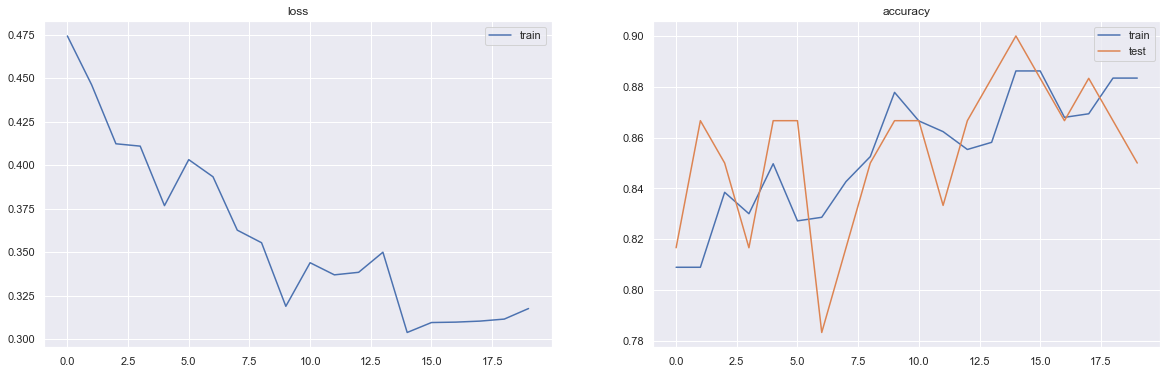

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.lineplot(list(range(len(train_losses))), train_losses, ax=ax[0], label="train")
sns.lineplot(list(range(len(train_acc))), train_acc, ax=ax[1], label="train")
sns.lineplot(list(range(len(val_acc))), val_acc, ax=ax[1], label="test")
ax[0].set_title("loss")
ax[1].set_title("accuracy")
plt.legend()
plt.show()

---

## 4.4 CNN回帰モデルによる画像の高解像度化

In [19]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [12]:
LFW_PATH_PREFIX = "dataset/lfw-deepfunneled"
TRAIN_PATH = f"{LFW_PATH_PREFIX}/train"
TEST_PATH = f"{LFW_PATH_PREFIX}/test"

In [13]:
class DownSizedPairImageFolder(ImageFolder):
    def __init__(self, root, transform=None, large_size=128, small_size=32, **kwds):
        super().__init__(root, transform=transform, **kwds)
        self.large_resizer = transforms.Resize(large_size)
        self.small_resizer = transforms.Resize(small_size)

    def __getitem__(self, index):
        path, _ = self.imgs[index]
        img = self.loader(path)

        # 読み取った画像を 128 * 128 ピクセルと 32 * 32 ピクセルにリサイズする
        large_img = self.large_resizer(img)
        small_img = self.small_resizer(img)

        # その他の変換を適用する
        if self.transform is not None:
            large_img = self.transform(large_img)
            small_img = self.transform(small_img)

        # 32ピクセルの画像と128ピクセルの画像を返す
        return small_img, large_img


def create_data_loader(batch_size=32):
    train_data = DownSizedPairImageFolder(TRAIN_PATH, transform=transforms.ToTensor())
    test_data = DownSizedPairImageFolder(TEST_PATH, transform=transforms.ToTensor())

    train_loader = DataLoader(
        train_data, batch_size=batch_size, shuffle=True, num_workers=2
    )
    test_loader = DataLoader(
        test_data, batch_size=batch_size, shuffle=False, num_workers=2
    )
    return train_loader, test_loader

- stride=2 は畳み込み層のカーネルをずらすときに2ピクセルずつ動かす
- Conv2d でこの設定をするとプーリング層の役割も兼ねるので MaxPool2d を入れなくても画像のサイズが 1/2 になる
- ConvTransposed2d は畳み込みそうカーネルを行列に展開したときに通常の畳み込みのときの行列の転置になる
    - Transposed Convolution を stride=2 で使用すると画像サイズがおおよそ2倍になる（入力と出力の画像のサイズがちょうど通常の畳込みと逆になる）
- Conv2d を2つ、ConvTransposed2d を4つをつなげた CNN を用意したので、これで4倍に拡大される
    - 畳み込み計算の都合上、微妙にサイズが2倍や1/2にズレてしまうので padding を入れて調整する（このあたりは実際にダミーのデータを入れて出力のサイズを確認しながら試行錯誤）

In [20]:
net = nn.Sequential(
    nn.Conv2d(3, 256, 4, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.Conv2d(256, 512, 4, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(512),
    nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1)
)

画像や音声などの信号の復元問題では MSE ではなく、PSNR という指標をよく使用する

In [21]:
import math
def psnr(mse, max_v=1.0):
    return 10 * math.log10(max_v ** 2 / mse)

In [ ]:
def eval_net(net, data_loader, device=DEVICE):
    net.eval()  # Dropout, BatchNorm を無効化
    ys = []
    ypreds = []
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            y_pred = net(x)
        ys.append(y)
        ypreds.append(y_pred)
    ys = torch.cat(ys)  # ミニバッチごとの予測結果などを一つにまとめる
    ypreds = torch.cat(ypreds)  # 同上
    score = nn.functional.mse_loss(ypreds, ys).item()  # .item() で値を取り出す
    return score, ys, ypreds


def train_net(
    net,
    train_loader,
    test_loader,
    optimizer_cls=optim.Adam,
    loss_fn=nn.MSELoss(),
    n_iter=10,
    device=DEVICE,
):
    train_losses = []
    return
